# Predicting avalanches on the Shara mountain

This notebook demonstrates the design of machine learning models that predict whether there will be an avalanche on a certain location. The input features are data like elevation, slope, snow index etc.

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import pandas as pd
from utils import AvalancheFeatures, plot_relative_importances, load_labels
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from joblib import dump

## Dataset

The dataset consists of 2 main parts:

* 2 `shp` files with lists of geographical coordinates on the Shara mountain. The first lists containes coordinates of locations where avalanches occurred, while the second list containes non-avalanche locations.
* Several `tif` files with geographical data such as elevation, slope, snow index etc.

This data is loaded into a dataframe for easier visualization and manipulation.  

In [2]:
# Define path to the data files
root = Path('../')
fitted_models_path = root / 'fitted_models'
data_path = root / 'data'
tif_files = list(data_path.glob('*.tif'))
results_path = root / 'results'

# Set to True if you want to save each trained model to disk
save_trained_models = False

# Figure size for the relative importance plots
feat_import_fig_size = (3.2, 2.4)

labels = load_labels(
    avalanches_path = data_path / 'Avalanches.shp',
    non_avalanches_path = data_path / 'Non avalanches.shp'
)
features = AvalancheFeatures(
    tif_paths = [data_path / file for file in tif_files],
    coords = labels['geometry'],
    verbose=False
)

print(features.df.head())

                         geometry  snow_index land_use  precipitation  \
0   POINT (502066.783 4667123.11)    0.625797  pasture     366.130646   
1   POINT (503361.101 4668079.36)    0.683000  pasture     362.346863   
2  POINT (504331.426 4669052.444)    0.611353  pasture     370.755280   
3  POINT (504889.997 4669887.542)    0.671356  pasture     374.118622   
4    POINT (505002.319 4669989.1)    0.558022  pasture     376.641144   

   plan_curvature  profile_curvature  temperature      slope      aspect  \
0        0.001673           0.004203    -4.642612  24.417328  north-west   
1       -0.004615          -0.002272    -4.469348  30.510981  north-west   
2       -0.000804           0.003009    -4.785888  48.290558  north-west   
3        0.008889           0.003421    -4.959152  34.450260  north-west   
4        0.004262           0.002404    -5.059112  30.125454  north-east   

     elevation  
0  2294.179932  
1  2243.219971  
2  2336.320068  
3  2387.280029  
4  2416.679932  


`sklearn` classes expect the data to be split into a feature matrix and a label vector.

In [3]:
# Get design matrix and label vector
X = features.get_X()

# Drop data points where some values are NaN
nan_idx = X[X.isnull().any(axis=1)].index
X = X.drop(index=nan_idx)
labels = labels.drop(index=nan_idx)

# Get label vector
y = labels['avalanche'].values.astype(int)

The data are randomly split into a train and test set, so that the proportion of avalanche vs non-avalanche examples remains the same as in the original unified dataset. 

The data are standardized based on the means and stdevs of features computed from the train set.

In [4]:
# Train-test split
idx_train, idx_test = train_test_split(
    range(len(y)), test_size=0.2, random_state=0, stratify=y
)

In [5]:
# Standardize
ss = StandardScaler(copy=True).fit(X.iloc[idx_train])
with open(fitted_models_path / f'scaler.pkl', 'wb') as f:
    dump(ss, f, protocol=5)
ss.set_output(transform='pandas')
X_scaled = ss.transform(X)

## Logistic regression

We use cross-validation to compute the optimal regularization hyper-parameter.

In [6]:
# Train
random_state = 0
lr = LogisticRegressionCV(
    cv=5, random_state=random_state, solver='saga', penalty='l1', max_iter=3000
).fit(X_scaled.iloc[idx_train], y[idx_train])

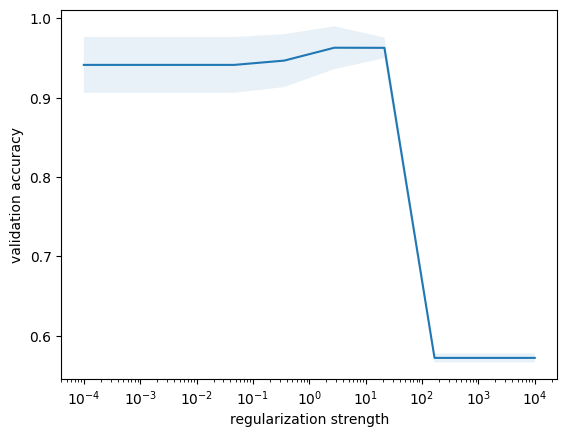

In [7]:
# Plot the validation curve
score_means = lr.scores_[1].mean(axis=0)
score_stds = lr.scores_[1].std(axis=0)
plt.semilogx(1/lr.Cs_, score_means)
plt.fill_between(
    1/lr.Cs_, score_means-score_stds, score_means+score_stds, alpha=0.1
)
plt.xlabel('regularization strength')
plt.ylabel('validation accuracy')
plt.show()

Evaluation on the test set demonstrates excellent accuracy.

In [8]:
# Predict
y_pred = lr.predict(X_scaled.iloc[idx_test])
print(classification_report(y[idx_test], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        20

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



Save best model to disk.

In [9]:
if save_trained_models:
    with open(fitted_models_path / f'lr.pkl', 'wb') as f:
        dump(lr, f, protocol=5)

### Feature importances

To classify each example, the model computes a linear combination of the standardized values of its features, with the weighting coefficients learned during training. The magnitudes of these weights can give an insight into the relative importance of features.

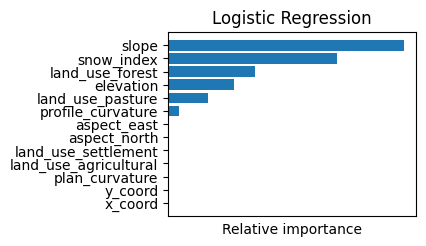

In [10]:
importances = np.abs(lr.coef_[0])
sorting_idx = np.argsort(importances)
if feat_import_fig_size is not None:
    plt.figure(figsize=feat_import_fig_size)
plt.barh(range(len(importances)), importances[sorting_idx], align='center')
plt.yticks(range(len(importances)), [X.columns[i] for i in sorting_idx])
plt.xticks([])
plt.xlabel('Relative importance')
plt.title('Logistic Regression')
plt.savefig(results_path / 'feat_import_lr.svg', bbox_inches='tight')
plt.show()


To verify the relative importances, we train a second model with just the top 3 most informative features.

In [11]:
# Train just with the top K features
top_feat_count = 3
idx_top = sorting_idx[-top_feat_count:]
X_top_feat = X_scaled.iloc[:, idx_top]
lr_top_feat = LogisticRegressionCV(cv=5, random_state=random_state).fit(
    X_top_feat.iloc[idx_train], y[idx_train]
)

# Evaluate
y_pred = lr_top_feat.predict(X_top_feat.iloc[idx_test])
print(classification_report(y[idx_test], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        20

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



In [12]:
if save_trained_models:
    with open(fitted_models_path / f'lr_top_{top_feat_count}_feats.pkl', 'wb') as f:
        dump(lr_top_feat, f, protocol=5)

## Decision Tree

Get the best combination of hyper-parameters through cross-validation.

In [13]:
max_depths = [2, 4, 8, 16, None]
min_samples_leaf = [1, 2, 5, 10]
random_state = 0

results = []
for md in max_depths:
    for msl in min_samples_leaf:
        dtc = DecisionTreeClassifier(
            max_depth=md, min_samples_leaf=msl, random_state=random_state
        )
        result = cross_validate(dtc, X_scaled.iloc[idx_train], y[idx_train], cv=3)
        results.append({
            'max_depth': md,
            'min_samples_leaf': msl,
            'test_score_mean': result['test_score'].mean(),
            'test_score_std': result['test_score'].std()
        })
results = pd.DataFrame(results)
print(results)

    max_depth  min_samples_leaf  test_score_mean  test_score_std
0         2.0                 1         0.930449        0.033201
1         2.0                 2         0.935825        0.026343
2         2.0                 5         0.930449        0.033201
3         2.0                10         0.919867        0.034612
4         4.0                 1         0.925073        0.040327
5         4.0                 2         0.930449        0.033201
6         4.0                 5         0.930449        0.033201
7         4.0                10         0.919867        0.034612
8         8.0                 1         0.925073        0.040327
9         8.0                 2         0.930449        0.033201
10        8.0                 5         0.930449        0.033201
11        8.0                10         0.919867        0.034612
12       16.0                 1         0.925073        0.040327
13       16.0                 2         0.930449        0.033201
14       16.0            

Evaluate the best-performing model on the test set.

In [14]:
idx_best = results['test_score_mean'].idxmax()
md = results.loc[idx_best, 'max_depth']
md = None if np.isnan(md) else int(md)
msl = results.loc[idx_best, 'min_samples_leaf']
dtc = DecisionTreeClassifier(
    max_depth=md, min_samples_leaf=msl, random_state=random_state
).fit(X_scaled.iloc[idx_train], y[idx_train])
y_pred = dtc.predict(X_scaled.iloc[idx_test])
print(classification_report(y[idx_test], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.87      1.00      0.93        20

    accuracy                           0.94        47
   macro avg       0.93      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47



Visualize the tree. Each box represents a node in the tree:

* the top line in the box specifies the test being performed
* the 2nd line show the Gini impurity of samples at that node
* the 3rd line shows how many samples from the train set reach that node
* the 4th line shows how many negative and positive examples are in the node

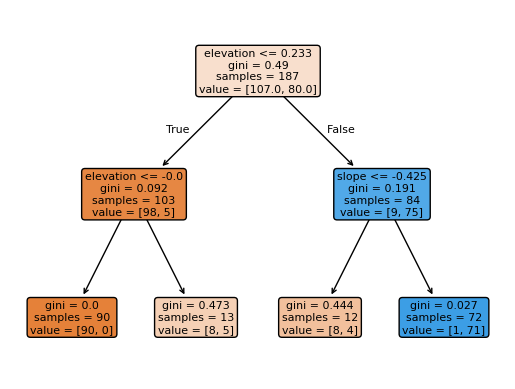

In [15]:
# fig, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(dtc, feature_names=X.columns, filled=True, rounded=True)
# plt.savefig('../results/tree.png', bbox_inches='tight', dpi=300)

In [16]:
# Save the tree as a fitted model
if save_trained_models:
    with open(fitted_models_path / f'dt.pkl', 'wb') as f:
        dump(dtc, f, protocol=5)

## Random Forest

Experiment to get the optimal combination of hyper-parameters, using the out-of-bag (OOB) score as the validation metric.

In [17]:
n_estimators = [20, 50, 100]
max_depths = [2, 4, 8, 16, None]
random_state = 0

In [18]:
# Random sample of hyper-parameter combinations
n_experiments = 5
results = []
random.seed(0)
for i in range(n_experiments):
    ne = random.choice(n_estimators)
    md = random.choice(max_depths)
    rf = RandomForestClassifier(
        n_estimators=ne, max_depth=md, oob_score=True, random_state=random_state
    ).fit(X_scaled, y)
    results.append({
        'n_estimators': ne, 'max_depth': md, 'oob_score': rf.oob_score_
    })

/Users/predrag.tadic/venvs/avalanches/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [19]:
# All hyper-parameter combinations
results = []
for ne in n_estimators:
    for md in max_depths:
        rf = RandomForestClassifier(
            n_estimators=ne, max_depth=md, oob_score=True, random_state=random_state
        ).fit(X_scaled, y)
        results.append({
            'n_estimators': ne, 'max_depth': md, 'oob_score': rf.oob_score_
        })
results = pd.DataFrame(results)
print(results)


/Users/predrag.tadic/venvs/avalanches/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/predrag.tadic/venvs/avalanches/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/predrag.tadic/venvs/avalanches/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/predrag.tadic/venvs/avalanches/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/predrag.tadic/venvs/avalanches/lib/py

    n_estimators  max_depth  oob_score
0             20        2.0   0.918803
1             20        4.0   0.948718
2             20        8.0   0.952991
3             20       16.0   0.952991
4             20        NaN   0.952991
5             50        2.0   0.940171
6             50        4.0   0.957265
7             50        8.0   0.961538
8             50       16.0   0.957265
9             50        NaN   0.957265
10           100        2.0   0.940171
11           100        4.0   0.957265
12           100        8.0   0.978632
13           100       16.0   0.978632
14           100        NaN   0.978632


Train the classifier with the best OOB score just on the training data,
validate on the test data.

In [20]:
idx_best = results['oob_score'].idxmax()
md = results.loc[idx_best, 'max_depth']
md = None if np.isnan(md) else int(md)
ne = results.loc[idx_best, 'n_estimators']
rf = RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=random_state)
rf.fit(X_scaled.iloc[idx_train], y[idx_train])
y_pred = rf.predict(X_scaled.iloc[idx_test])
print(classification_report(y[idx_test], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.95      1.00      0.98        20

    accuracy                           0.98        47
   macro avg       0.98      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47



[]

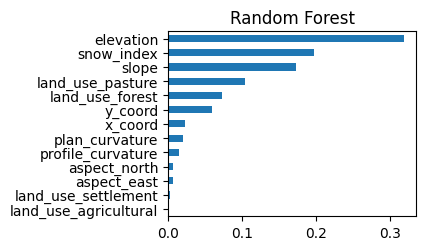

In [41]:
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values()
if feat_import_fig_size is not None:
    plt.figure(figsize=feat_import_fig_size)
rf_importances.plot.barh()
plt.title('Random Forest')
plt.savefig(results_path / 'feat_import_rf.svg', bbox_inches='tight')
plt.plot()

In [22]:
if save_trained_models:
    with open(fitted_models_path / f'rf.pkl', 'wb') as f:
        dump(rf, f, protocol=5)

## SVM

### Linear kernel

In [23]:
# Cs = [0.1, 0.5, 1, 5, 10, 50, 100]
Cs = np.logspace(-1, 2, num=30)
random_state = 0

results = []
for C in Cs:
    svc = SVC(C=C, random_state=random_state, kernel='linear', probability=True)
    result = cross_validate(svc, X_scaled.iloc[idx_train], y[idx_train], cv=3)
    results.append({
        'C': C,
        'test_score_mean': result['test_score'].mean(),
        'test_score_std': result['test_score'].std()
    })
results = pd.DataFrame(results)
print(results.head())

          C  test_score_mean  test_score_std
0  0.100000         0.946407        0.030535
1  0.126896         0.946407        0.030535
2  0.161026         0.951698        0.026443
3  0.204336         0.951698        0.026443
4  0.259294         0.946407        0.030535


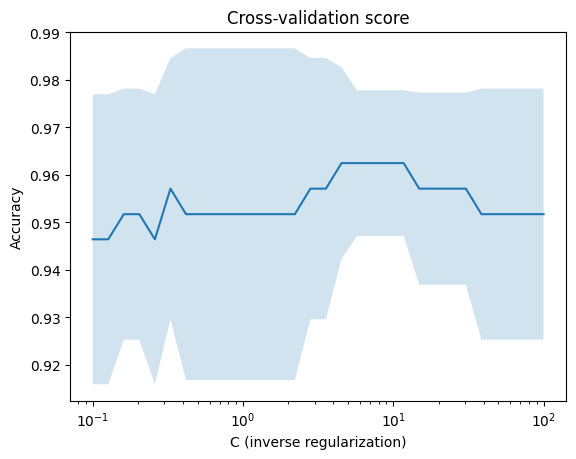

Best hyper-parameter:
C                  4.520354
test_score_mean    0.962451
test_score_std     0.020208
Name: 16, dtype: float64


In [24]:
plt.semilogx(Cs, results['test_score_mean'])
plt.fill_between(
    Cs, results['test_score_mean'] - results['test_score_std'],
    results['test_score_mean'] + results['test_score_std'],
    alpha=0.2
)
plt.xlabel('C (inverse regularization)')
plt.ylabel('Accuracy')
plt.title('Cross-validation score')
plt.show()

idx_best = results['test_score_mean'].idxmax()
C_best = results.loc[idx_best, 'C']
print(f'Best hyper-parameter:\n{results.loc[idx_best]}')

Evaluation on the test set.

In [25]:
# Predict
svm_lin = SVC(C=C_best, random_state=random_state, kernel='linear', probability=True).fit(
    X_scaled.iloc[idx_train], y[idx_train]
)
y_pred = svm_lin.predict(X_scaled.iloc[idx_test])
print(classification_report(y[idx_test], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.91      1.00      0.95        20

    accuracy                           0.96        47
   macro avg       0.95      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47



To classify each example, the model computes a linear combination of the standardized values of its features, with the weighting coefficients learned during training. The magnitudes of these weights can give an insight into the relative importance of features.

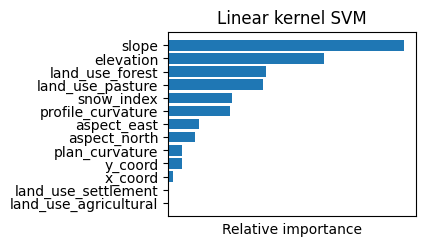

In [26]:
plot_relative_importances(
    importances=np.abs(svm_lin.coef_[0]),
    feature_names=X.columns,
    title='Linear kernel SVM',
    save_path = results_path / 'feat_import_lsvm.svg',
    fig_size=feat_import_fig_size
)

In [27]:
if save_trained_models:
    with open(fitted_models_path / f'linear_svm.pkl', 'wb') as f:
        dump(svm_lin, f, protocol=5)

### Gaussian kernel

In [28]:
Cs = np.logspace(-1, 2, num=30)
gammas = np.logspace(-3, 0, num=30)
random_state = 0

# Random sample of hyper-parameter combinations
n_experiments = 100
results = []
random.seed(0)
for i in range(n_experiments):
    C = random.choice(Cs)
    gamma = random.choice(gammas)
    svc = SVC(C=C, gamma=gamma, random_state=random_state, probability=True)
    result = cross_validate(svc, X_scaled.iloc[idx_train], y[idx_train], cv=3)
    results.append({
        'C': C, 'gamma': gamma, 
        'test_score_mean': result['test_score'].mean(),
        'test_score_std': result['test_score'].std()
    })
results = pd.DataFrame(results)
print(results.head())

           C     gamma  test_score_mean  test_score_std
0  62.101694  0.017433         0.956989        0.040233
1  30.391954  0.788046         0.898276        0.030719
2   2.212216  0.001269         0.919696        0.013590
3   0.672336  0.045204         0.946493        0.020188
4   3.562248  0.017433         0.951698        0.026443


Evaluation on the test set.

In [29]:
# Predict
idx_best = results['test_score_mean'].idxmax()
C_best = results.loc[idx_best, 'C']
gamma_best = results.loc[idx_best, 'gamma']
print(f'Best hyper-parameters:\n{results.loc[idx_best]}')

svm_rbf = SVC(
    C=C_best, gamma=gamma_best, random_state=random_state, probability=True
).fit(
    X_scaled.iloc[idx_train], y[idx_train]
)
y_pred = svm_rbf.predict(X_scaled.iloc[idx_test])
print('\nEvaluation on test set:')
print(classification_report(y[idx_test], y_pred))

Best hyper-parameters:
C                  38.566204
gamma               0.092367
test_score_mean     0.962451
test_score_std      0.030474
Name: 16, dtype: float64

Evaluation on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        20

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



Since the Gaussian kernel SVM is defined in the dual form, we cannot directly relate feature importance with the coefficient magnitudes. Instead, we test how sensitive the model is to a random shuffling of an individual feature's values. For non important features, this shuffling will not cause a significant drop in accuracy. 

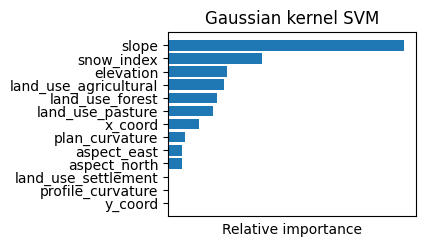

In [30]:
results = permutation_importance(
    svm_rbf, X_scaled.iloc[idx_test], y[idx_test], n_repeats=10, random_state=random_state
)
plot_relative_importances(
    results.importances_mean, X.columns, title='Gaussian kernel SVM',
    save_path = results_path / 'feat_import_gsvm.svg',
    fig_size=feat_import_fig_size
)

In [31]:
if save_trained_models:
    with open(fitted_models_path / f'gaussian_svm.pkl', 'wb') as f:
        dump(svm_rbf, f, protocol=5)

## Multi-Layer Perceptron 

In [32]:
max_layer_size = 100
max_num_layers = 3
random_state = 0

# Random sample of hyper-parameter combinations
n_experiments = 20
results = []
random.seed(0)
for i in range(n_experiments):
    num_layers = random.randint(a=1, b=max_num_layers)
    layer_sizes = []
    for _ in range(num_layers):
        layer_sizes.append(random.randint(a=5, b=max_layer_size))
    mlp = MLPClassifier(
        hidden_layer_sizes=layer_sizes, 
        random_state=random_state, 
        max_iter=1000
    )
    result = cross_validate(mlp, X_scaled.iloc[idx_train], y[idx_train], cv=3)
    results.append({
        'layer_sizes': layer_sizes, 
        'test_score_mean': result['test_score'].mean(),
        'test_score_std': result['test_score'].std()
    })
results = pd.DataFrame(results)
print(results.head())

    layer_sizes  test_score_mean  test_score_std
0      [58, 10]         0.956989        0.040233
1      [70, 67]         0.956989        0.040233
2      [43, 66]         0.956989        0.040233
3      [79, 32]         0.951613        0.047483
4  [22, 41, 22]         0.951613        0.039508


In [33]:
# Predict
idx_best = results['test_score_mean'].idxmax()
layer_sizes_best = results.loc[idx_best, 'layer_sizes']
print(f'Best hyper-parameters:\n{results.loc[idx_best]}')

mlp = MLPClassifier(
    hidden_layer_sizes=layer_sizes_best, 
    random_state=random_state, 
    max_iter=1000
).fit(X_scaled.iloc[idx_train], y[idx_train])
y_pred = mlp.predict(X_scaled.iloc[idx_test])
print('\nEvaluation on test set:')
print(classification_report(y[idx_test], y_pred))

Best hyper-parameters:
layer_sizes        [12, 75]
test_score_mean    0.973118
test_score_std     0.027414
Name: 13, dtype: object

Evaluation on test set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.95      1.00      0.98        20

    accuracy                           0.98        47
   macro avg       0.98      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47



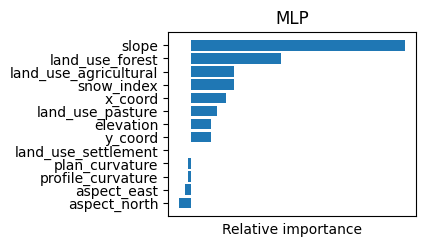

In [34]:
results = permutation_importance(
    mlp, X_scaled.iloc[idx_test], y[idx_test], n_repeats=10, random_state=0
)
plot_relative_importances(
    results.importances_mean, X.columns, title='MLP', fig_size=feat_import_fig_size
)

In [35]:
if save_trained_models:
    with open(fitted_models_path / f'mlp.pkl', 'wb') as f:
        dump(mlp, f, protocol=5)

## LightGBM

In [36]:
random_state = 0
lgbm = LGBMClassifier(
    max_depth=8,
    min_data_in_leaf=4,
    random_state=random_state
).fit(X_scaled.iloc[idx_train], y[idx_train])
y_pred = lgbm.predict(X_scaled.iloc[idx_test])
print('\nEvaluation on test set:')
print(classification_report(y[idx_test], y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Info] Number of positive: 80, number of negative: 107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 187, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427807 -> initscore=-0.290802
[LightGBM] [Info] Start training from score -0.290802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [37]:
if save_trained_models:
    with open(fitted_models_path / f'lgbm.pkl', 'wb') as f:
        dump(lgbm, f, protocol=5)

## XGBoost

In [38]:
# Define the hyperparameter distributions
random_state = 0
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.5),
    'subsample': stats.uniform(loc=0.5, scale=0.5),
    'n_estimators':stats.randint(20, 200)
}

# Create the XGBoost model object
xgb = XGBClassifier(random_state=random_state)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy'
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_scaled.iloc[idx_train], y[idx_train])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': np.float64(0.136026428782199), 'max_depth': 9, 'n_estimators': 47, 'subsample': np.float64(0.7030878139791524)}
Best score:  0.9625889046941678


In [39]:
xgb = XGBClassifier(
    n_estimators=150, 
    max_depth=7,
    subsample=0.9,
    learning_rate=0.5,     
    objective='binary:logistic',
    random_state=random_state
)
xgb.fit(X_scaled.iloc[idx_train], y[idx_train])
y_pred = xgb.predict(X_scaled.iloc[idx_test])
print('\nEvaluation on test set:')
print(classification_report(y[idx_test], y_pred))


Evaluation on test set:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.91      1.00      0.95        20

    accuracy                           0.96        47
   macro avg       0.95      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47



In [40]:
if save_trained_models:
    with open(fitted_models_path / f'xgb.pkl', 'wb') as f:
        dump(xgb, f, protocol=5)